# LA Metro Bikeshare EDA
1. Story planning
2. Obtain data sets - D
3. Obtain lat longs with scraper
4. Clean data sets 
5. Feature engineering
6. Visualization
7. TBD

Is there a predictive value that can be derived for kinds of locations
    1. Finding lat long coordinates of schools or public services and mapping out color coded heat maps based on the type of establishment
    2. Finding out where most bike stations are likely to be located
    3. Goal is to find out where you would set up more bike locations + figure out why particular locations are popular and predict accordingly

In [395]:
# importing necessary packages
import pandas as pd
import pprint
import missingno as msno
from urllib.request import Request, urlopen
import json
from bs4 import BeautifulSoup
import requests
import re

# Core rides dataset

In [37]:
# there are 4 files for the data for each quarter from 2017 Q3 to 2018 Q2
_2017Q3 = pd.read_csv('../data/external/2017Q3.csv')
_2017Q4 = pd.read_csv('../data/external/2017Q4.csv')
_2018Q1 = pd.read_csv('../data/external/2018Q1.csv')
_2018Q2 = pd.read_csv('../data/external/2018Q2.csv')

In [38]:
# concatenate the four quarters of ride sharing data into a year's worth
rides_df = pd.concat([_2017Q3,_2017Q4,_2018Q1,_2018Q2])
rides_df.shape

(286295, 14)

In [39]:
rides_df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,33404951,36,7/1/2017 0:09,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,5996,0,Round Trip,Walk-up
1,33404950,13,7/1/2017 0:10,7/1/2017 0:23,3055,34.044159,-118.251579,3082,34.046520,-118.237411,5777,0,One Way,Walk-up
2,33404947,34,7/1/2017 0:11,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6342,0,Round Trip,Walk-up
3,33404948,34,7/1/2017 0:11,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6478,0,Round Trip,Walk-up
4,33404949,12,7/1/2017 0:11,7/1/2017 0:23,3055,34.044159,-118.251579,3082,34.046520,-118.237411,6411,0,One Way,Walk-up


In [40]:
rides_df.describe()

,trip_id,duration,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration
count,2.862950e+05,286295.000000,286295.00000,285660.000000,285660.000000,286295.000000,281900.000000,281900.000000,286295.000000,286295.000000
mean,6.480957e+07,35.034206,3420.79971,34.045820,-118.271421,3414.716265,34.045689,-118.271667,7900.573014,30.907910
std,1.808223e+07,115.722913,538.47854,0.065529,0.097562,537.212309,0.065038,0.098157,2717.473129,66.243336
min,3.340494e+07,1.000000,3000.00000,33.710979,-118.491341,3000.000000,33.710979,-118.491341,4727.000000,0.000000
25%,4.905606e+07,7.000000,3031.00000,34.039982,-118.262733,3031.000000,34.039982,-118.262733,6053.000000,0.000000
50%,6.534754e+07,12.000000,3064.00000,34.046822,-118.252441,3063.000000,34.046810,-118.252830,6403.000000,30.000000
75%,8.085881e+07,25.000000,4156.00000,34.053200,-118.237411,4156.000000,34.051941,-118.237410,12019.000000,30.000000
max,9.508575e+07,1440.000000,4254.00000,34.165291,-118.116530,4254.000000,34.165291,-118.116530,12456.000000,365.000000


In [41]:
rides_df.dtypes

trip_id                  int64
duration                 int64
start_time              object
end_time                object
start_station            int64
start_lat              float64
start_lon              float64
end_station              int64
end_lat                float64
end_lon                float64
bike_id                  int64
plan_duration            int64
trip_route_category     object
passholder_type         object
dtype: object

On first glance, all time variables like start_time and end_time should be converted to a date time object.

In [312]:
# converting start and end times to datetime objects
def col_to_datetime(column):
    column = pd.to_datetime(column)

rides_df['start_time'] = pd.to_datetime(rides_df['start_time'])
rides_df['end_time'] = pd.to_datetime(rides_df['end_time'])

In [52]:
# checking to see if columns were indeed converted
rides_df.dtypes

trip_id                         int64
duration                        int64
start_time             datetime64[ns]
end_time               datetime64[ns]
start_station                   int64
start_lat                     float64
start_lon                     float64
end_station                     int64
end_lat                       float64
end_lon                       float64
bike_id                         int64
plan_duration                   int64
trip_route_category            object
passholder_type                object
dtype: object

In [54]:
# quick look at which station is the most commonly used and where it is (Venice beach)
rides_df['start_station'].mode()

0    4214
dtype: int64

In [53]:
rides_df[rides_df['start_station'] == 4214].head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
51390,44620579,16,2017-09-07 10:40:00,2017-09-07 10:56:00,4214,33.99556,-118.481552,4216,34.023392,-118.479637,11200,30,One Way,Monthly Pass
51391,44627346,28,2017-09-07 10:40:00,2017-09-07 11:08:00,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12416,365,One Way,Flex Pass
51393,44641142,167,2017-09-07 10:40:00,2017-09-07 13:27:00,4214,33.99556,-118.481552,4212,33.988129,-118.471741,12241,365,One Way,Flex Pass
51394,44620577,17,2017-09-07 10:41:00,2017-09-07 10:58:00,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12356,30,One Way,Monthly Pass
51395,44627343,28,2017-09-07 10:41:00,2017-09-07 11:09:00,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12431,30,One Way,Monthly Pass


Here we use the missingno package to check for NA values in the dataframe. As the number of missing values seem almost negligible compared to the total number of observations, we drop the rows. Around 4849 rows, or 1.7% of total rows were dropped.

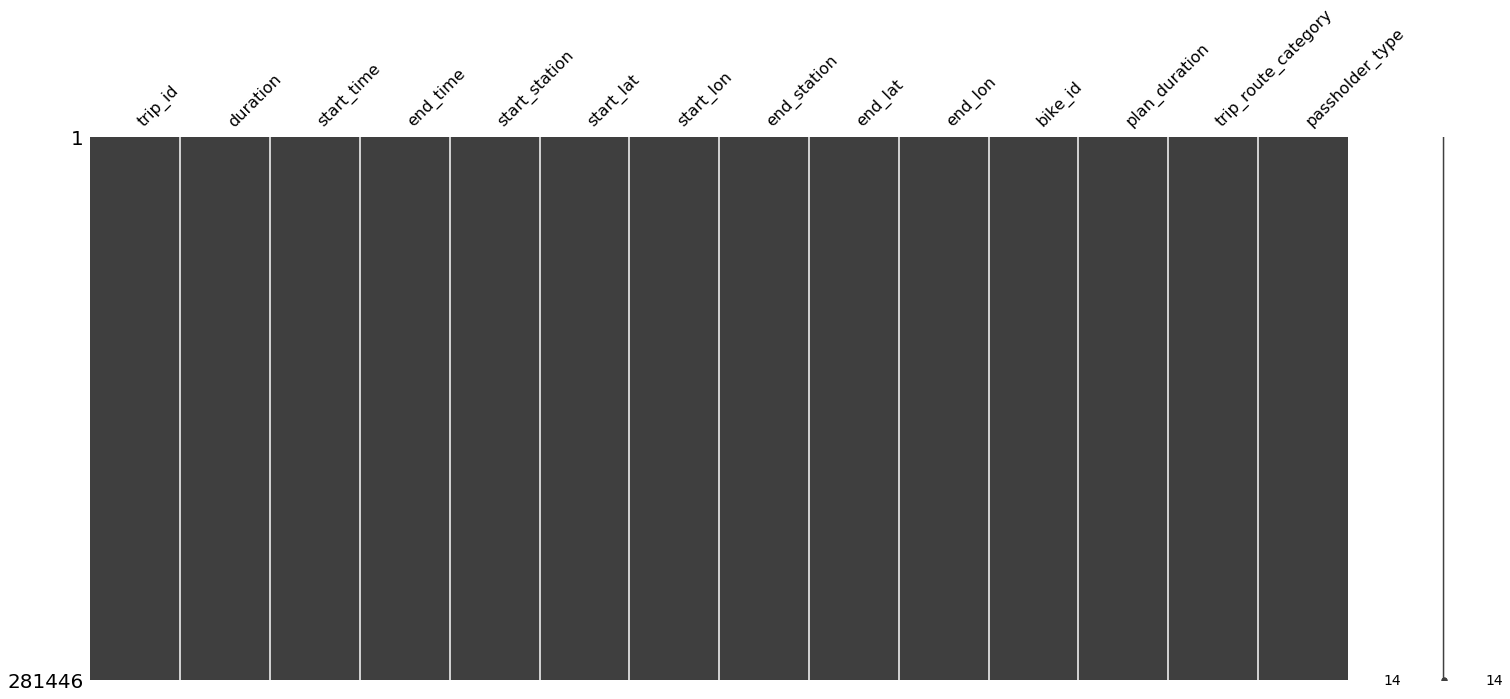

In [55]:
# check for missing values
%matplotlib inline
msno.matrix(rides_df)

In [47]:
# dropping rows with na values
rides_df = rides_df.dropna()
rides_df.shape

(281446, 14)

# External datasets of geolocations

In order to obtain a perspective of where most rides occur and landmarks around LA, we utilize multiple data sources and APIs to obtain the relevant latitude and longitude values.

### Bike station locations
We first start off with more detailed information on the bike stations. To do this, we download the json file from https://bikeshare.metro.net/stations/json/ which includes addresses and capacities of different bike stations.

In [139]:
# read in the json file with station information
with open ('../data/external/bike_stations.json') as f:
    station_data = json.load(f)

In [140]:
# extract useful columns from the jason and append it to a list
all_station_info = []
for station in station_data['features']: 
    station_attr = []
    station_attr.append([station['properties']['kioskId'], station['properties']['addressStreet'], 
                         station['properties']['addressZipCode'], station['properties']['name'],
                         station['properties']['totalDocks']])
    all_station_info.append(station_attr[0])

In [141]:
# check to see if each element in list is a list of station attributes we need
all_station_info[2]

[3007, '557 S 5th Street', '90071', '5th & Grand', 23]

In [142]:
# create new dataframe based on the attributes
stations_info = pd.DataFrame(all_station_info, columns=['kiosk_id','address_street','address_zip','station_name','total_docks'])
stations_info.head()

,kiosk_id,address_street,address_zip,station_name,total_docks
0,3005,723 Flower Street,90017,7th & Flower,27
1,3006,729 S Olive Street,90014,Olive & 8th,24
2,3007,557 S 5th Street,90071,5th & Grand,23
3,3008,865 S Figueroa Street,90017,Figueroa & 9th,15
4,3010,401 East 11th Street,90015,11th & Maple,22


In [163]:
# adding start station attributes
rides_df = pd.merge(rides_df, stations_info, how = "left", left_on = 'start_station', 
               right_on = ['kiosk_id']).rename(columns = {'address_street':'start_address',
                                                          'address_zip':'start_zip','station_name':'start_name',
                                                          'total_docks':'start_docks'}).drop('kiosk_id',1)
# adding end station attributes
rides_df = pd.merge(rides_df, stations_info, how = "left", left_on = 'end_station', 
               right_on = ['kiosk_id']).rename(columns = {'address_street':'end_address',
                                                          'address_zip':'end_zip','station_name':'end_name',
                                                          'total_docks':'end_docks'}).drop('kiosk_id',1)

In [303]:
rides_df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,...,trip_route_category,passholder_type,start_address,start_zip,start_name,start_docks,end_address,end_zip,end_name,end_docks
0,33404951,36,2017-07-01 00:09:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,...,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0
1,33404950,13,2017-07-01 00:10:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,...,One Way,Walk-up,111 W 7th Street,90014,7th & Main,23.0,599 Traction Ave,90013,Traction & Rose,27.0
2,33404947,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,...,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0
3,33404948,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,...,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0
4,33404949,12,2017-07-01 00:11:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,...,One Way,Walk-up,111 W 7th Street,90014,7th & Main,23.0,599 Traction Ave,90013,Traction & Rose,27.0


In [306]:
print('Dates range from: ', rides_df['start_time'].min(), ' to ', rides_df['start_time'].max())

Dates range from:  2017-07-01 00:09:00  to  2018-06-30 23:52:00


### Active businesses

https://data.lacity.org/A-Prosperous-City/Listing-of-Active-Businesses/6rrh-rzua

In [365]:
# reading in csv file of active businesses, could be outside of LA
business_df = pd.read_csv('../data/external/active_businesses.csv')

In [366]:
business_df.head()

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION
0,0000000115-0001-3,VINCENZO LABELLA,NaN,521 SWARTHMORE AVENUE,PACIFIC PALISADES,90272-4350,521 SWARTHMORE 90272-4350,521 SWARTHMORE AVENUE,PACIFIC PALISADES,90272-4350,561500.0,Travel arrangement & reservation services,11,01/01/1990,NaN,NaN
1,0000000150-0001-5,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,2015 W TEMPLE STREET,LOS ANGELES,90026-4913,2015 TEMPLE 90026-4913,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",13,01/01/1991,NaN,NaN
2,0000000156-0001-2,SPRINGBOARD NON-PROFIT CONSUMER CREDIT MANAGEMENT,MONEY MANAGEMENT INTERNATIONAL,1605 W OLYMPIC BLVD #9023,LOS ANGELES,90015-3828,1605 OLYMPIC 90015-3828,NaN,NaN,NaN,523900.0,Other financial investment activities (includi...,1,02/01/1999,NaN,NaN
3,0000000225-0001-5,STRATEGIC CONCEPTS IN ORGANIZING AND POLICY ED...,NaN,1715 W FLORENCE AVENUE,LOS ANGELES,90047-2220,1715 FLORENCE 90047-2220,NaN,NaN,NaN,611000.0,"Educational services (including schools, colle...",8,06/03/1997,NaN,NaN
4,0000000247-0001-1,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,3806 W PICO BLVD,LOS ANGELES,90019-4304,3806 PICO 90019-4304,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",10,01/01/1991,NaN,NaN


In [367]:
# check to see how many different cities there are in the column
business_df['CITY'].unique()

array(['PACIFIC PALISADES', 'LOS ANGELES', 'GRANADA HILLS', ..., 'ARDEN',
       'LOS BANOS', 'DEBARY'], dtype=object)

As the focus of the ride sharing data is in the LA metro area, we will only focus on the data in that area and only include data with the city variable matching 'Los Angeles'.

By doing so, we see that around 50% of the initial dataset remains.

In [368]:
business_df = business_df[business_df['CITY'] == 'LOS ANGELES']
business_df.shape

(250920, 16)

A look at the dataframe also reveals many NaN values. Using msno, we see that there are multiple columns like 'DBA NAME' and 'MAILING CITY' that are almost completely empty.

There are also many variables that are not as relevant in our analysis. Our main purpose of obtaining the dataset of active businesses is to visualize their locations. We will thus select only the relevant columns and rename them accordingly.

In [369]:
business_df.head()

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION
1,0000000150-0001-5,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,2015 W TEMPLE STREET,LOS ANGELES,90026-4913,2015 TEMPLE 90026-4913,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",13,01/01/1991,NaN,NaN
2,0000000156-0001-2,SPRINGBOARD NON-PROFIT CONSUMER CREDIT MANAGEMENT,MONEY MANAGEMENT INTERNATIONAL,1605 W OLYMPIC BLVD #9023,LOS ANGELES,90015-3828,1605 OLYMPIC 90015-3828,NaN,NaN,NaN,523900.0,Other financial investment activities (includi...,1,02/01/1999,NaN,NaN
3,0000000225-0001-5,STRATEGIC CONCEPTS IN ORGANIZING AND POLICY ED...,NaN,1715 W FLORENCE AVENUE,LOS ANGELES,90047-2220,1715 FLORENCE 90047-2220,NaN,NaN,NaN,611000.0,"Educational services (including schools, colle...",8,06/03/1997,NaN,NaN
4,0000000247-0001-1,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,3806 W PICO BLVD,LOS ANGELES,90019-4304,3806 PICO 90019-4304,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",10,01/01/1991,NaN,NaN
5,0000000267-0001-9,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,3115 VENICE BLVD,LOS ANGELES,90019-6238,3115 VENICE 90019-6238,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",10,01/01/1991,NaN,NaN


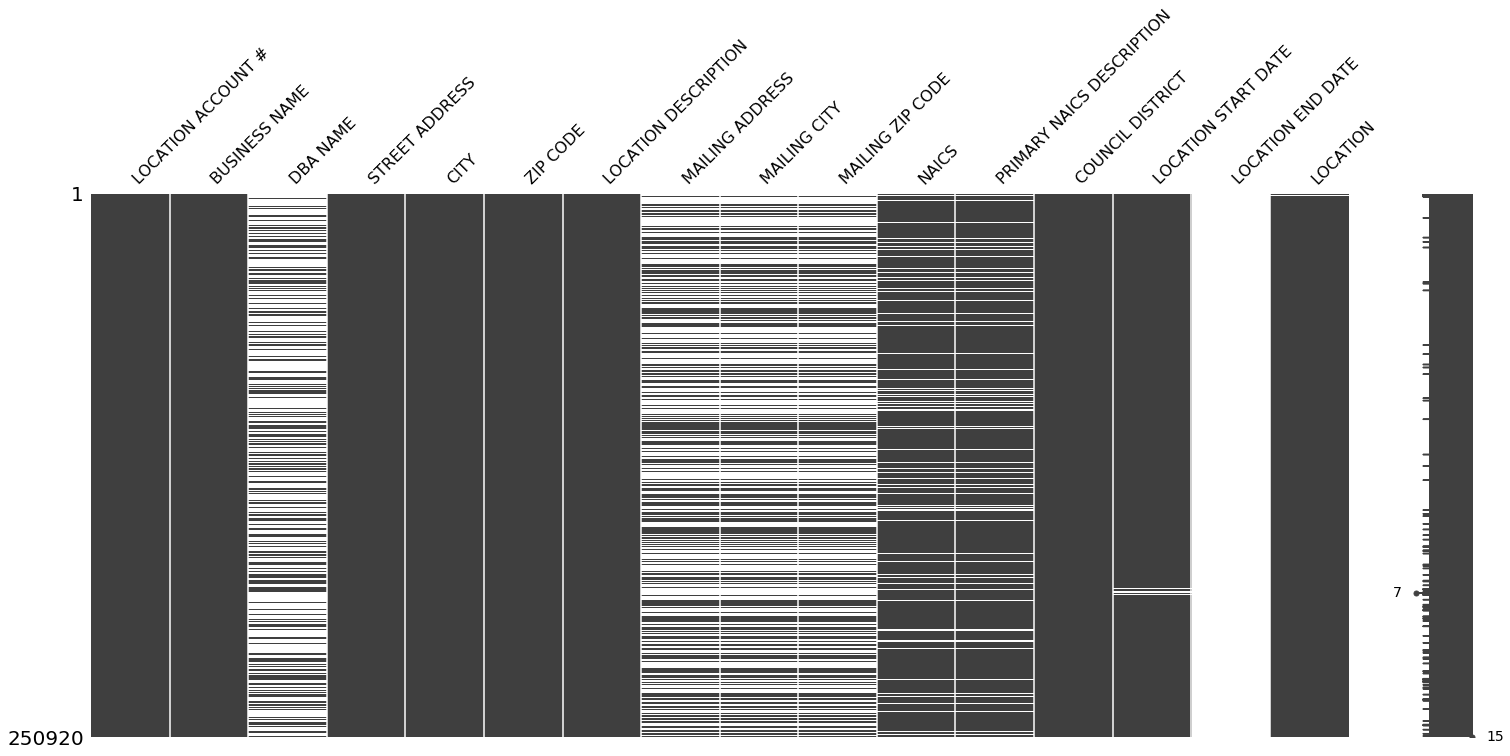

In [370]:
msno.matrix(business_df)

In [371]:
business_df = business_df[['BUSINESS NAME', 'STREET ADDRESS', 'ZIP CODE', 'LOCATION START DATE', 'LOCATION']].rename(columns = {'BUSINESS NAME':'business_name', 'STREET ADDRESS':'street_address', 'ZIP CODE':'zip_code', 'LOCATION START DATE':'start_date', 'LOCATION':'coordinates'})
business_df.head()

,business_name,street_address,zip_code,start_date,coordinates
1,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,2015 W TEMPLE STREET,90026-4913,01/01/1991,NaN
2,SPRINGBOARD NON-PROFIT CONSUMER CREDIT MANAGEMENT,1605 W OLYMPIC BLVD #9023,90015-3828,02/01/1999,NaN
3,STRATEGIC CONCEPTS IN ORGANIZING AND POLICY ED...,1715 W FLORENCE AVENUE,90047-2220,06/03/1997,NaN
4,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,3806 W PICO BLVD,90019-4304,01/01/1991,NaN
5,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,3115 VENICE BLVD,90019-6238,01/01/1991,NaN


There seems to be quite a few businesses that do not have coordinates. A quick filter reveals 1583 of them. These seem to be businesses that were incorporate very early on before 2000. As this is a very small portion of the dataset, we can safely drop them.

Another anomaly that popped up were coordinates of (0,0). As this is a location in the middle of the ocean, these coordinates are unlikely to mean anything and will be dropped.

In [372]:
# counting the number of businesses without coordinates
business_df['coordinates'].isna().sum()

1583

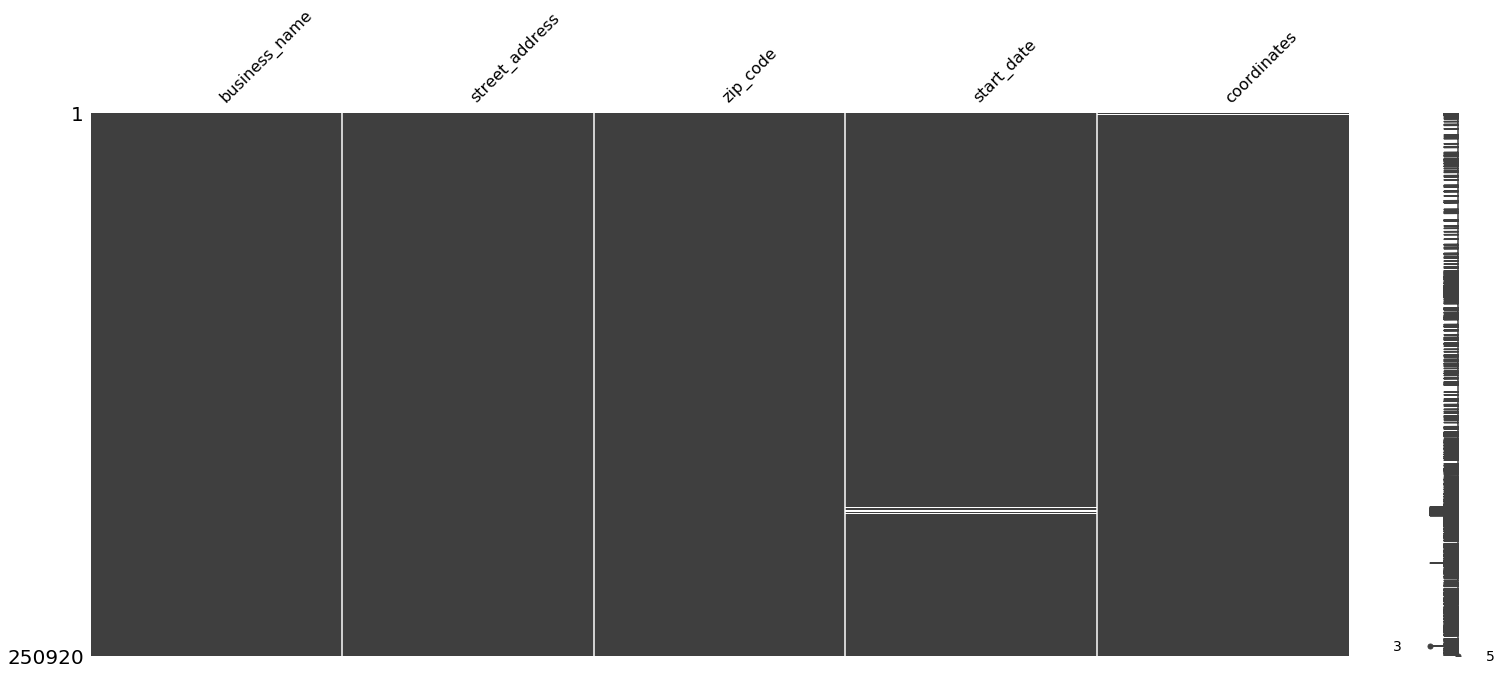

In [375]:
msno.matrix(business_df)

In [383]:
# dropping na coordinate values
business_df = business_df.dropna()

,index,business_name,street_address,zip_code,start_date,coordinates
0,10,CORALIE WHITCOMB,2669 MEDLOW AVENUE,90065-4616,06/10/2017,"(34.1269, -118.2247)"
1,45,CASA VELA INC,2710 E CESAR CHAVEZ AVENUE,90033-,09/19/2017,"(0, 0)"
2,56,RMJC INSURANCE SERVICES INC,1601 S VERMONT AVENUE SUITE #103,90006-4541,03/07/2017,"(34.044, -118.292)"
3,59,DANIELLE HALFERTY,2527 CANYON DRIVE,90068-2415,09/18/2017,"(34.1164, -118.3165)"
4,61,PETER J HARRIS,4153 MARLTON AVENUE #3,90008-3525,01/01/1998,"(34.0101, -118.3416)"


In [393]:
# dropping coordinates of (0,0) and resetting the index to start from 0
business_df = business_df[business_df['coordinates'] != '(0, 0)'].reset_index()
business_df.shape

(245437, 7)

In [394]:
business_df.loc[1]['coordinates']

'(34.044, -118.292)'

As the coordinate variable is a string with the latitude and longitude values, we shall use regex functions to pull the latitude and longtitude variables out and convert them to a float type. 

Here we use positive lookbehind and positive lookahead to target the exact part of the string that we need because each latitude and longitude pair has the same structure.

In [412]:
# regex to extract latitude
def get_lat(coords):
    lat = re.compile('(?<=\().+(?=\,)')
    return float(lat.search(coords).group())

# regex to extract longitude
def get_long(coords):
    long = re.compile('(?<=\, ).+(?=\))')
    return float(long.search(coords).group())

print("latitude: " + str(get_lat(business_df.loc[1]['coordinates'])) + " longitude: " + str(get_long(business_df.loc[1]['coordinates'])))

latitude: 34.044 longitude: -118.292


In [422]:
# apply get_lat and get_long functions to create new columns representing latitude and longitude for each business
business_df['latitude'] = business_df['coordinates'].apply(get_lat)
business_df['longitude'] = business_df['coordinates'].apply(get_long)
business_df = business_df.drop(['coordinates'],axis=1)
business_df.head()

,level_0,index,business_name,street_address,zip_code,start_date,latitude,longitude
0,0,10,CORALIE WHITCOMB,2669 MEDLOW AVENUE,90065-4616,06/10/2017,34.1269,-118.2247
1,2,56,RMJC INSURANCE SERVICES INC,1601 S VERMONT AVENUE SUITE #103,90006-4541,03/07/2017,34.0440,-118.2920
2,3,59,DANIELLE HALFERTY,2527 CANYON DRIVE,90068-2415,09/18/2017,34.1164,-118.3165
3,4,61,PETER J HARRIS,4153 MARLTON AVENUE #3,90008-3525,01/01/1998,34.0101,-118.3416
4,5,62,CARNIVAL LUXE LLC,234 S FIGUEROA STREET APARTMENT #1235,90012-2525,12/06/2016,34.0559,-118.2536


### Crimes 2010-2018

https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-Present/y8tr-7khq

In [381]:
crimes_df = pd.read_csv('../data/external/crime_2010_2018.csv')

### Traffic collisions 2010-2018

https://www.kaggle.com/cityofLA/los-angeles-traffic-collision-data/version/7#traffic-collision-data-from-2010-to-present.csv

In [301]:
traffic_df = pd.read_csv('../data/external/traffic_collisions_2010_2018.csv')

In [302]:
traffic_df['Date Occurred'].max()

'2018-08-11T00:00:00'